<a href="https://colab.research.google.com/github/Alsham0/BERT-IA/blob/main/analisis_bert_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analizador de sentimientos**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.7 MB/s eta 0:00:00


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

In [ ]:
DATASET_PATH = 'IMDB_Dataset.csv'
MAX_LEN = 200
BATCH_SIZE = 16
NCLASSES = 2
RANDOM_SEED = 42


np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
df = pd.read_csv(DATASET_PATH)
df = df[0:10000]
print(df.head())
print(df.shape)
print("\n".join(wrap(df['review'][200])))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(10000, 2)
Interesting and short television movie describes some of the
machinations surrounding Jay Leno's replacing Carson as host of the
Tonight Show. Film is currently very topical given the public drama
surrounding Conan O'Brien and Jay Leno.<br /><br />The film does a
good job of sparking viewers' interest in the events and showing some
of the concerns of the stakeholders, particularly of the NBC
executives. The portrayal of Ovitz was particularly compelling and
interesting, I thought.<br /><br />Still, many of the characters were
only very briefly limned or touched upon, and some of the acting
seemed perfunc

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

<Axes: xlabel='sentiment', ylabel='count'>

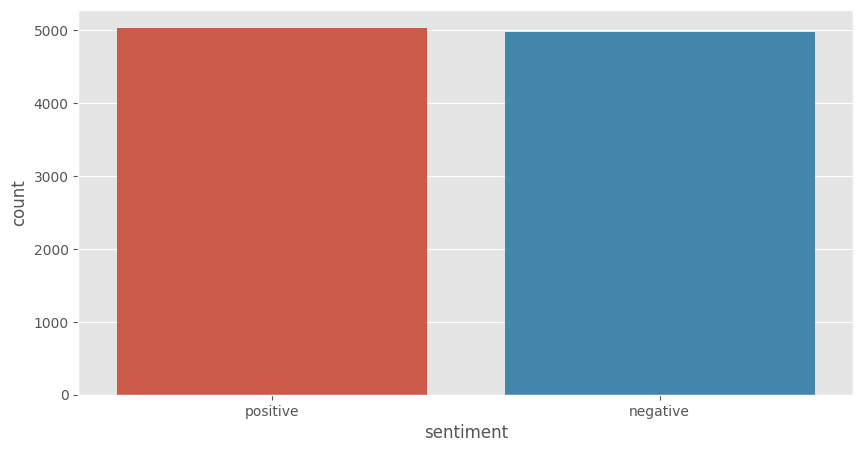

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='sentiment', data = df)

In [ ]:
df['label'] = (df['sentiment']=='positive').astype(int)
df.drop('sentiment', axis=1, inplace=True)
df.head()

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


**Bert base cased**

Modelo preentrenado en idioma inglés utilizando un objetivo de modelado de lenguaje enmascarado (MLM).

BERT es un modelo de transformadores preentrenado en un gran corpus de datos en inglés de manera autosupervisada. Esto significa que fue entrenado previamente solo con los textos sin procesar, sin que los humanos los etiqueten de ninguna manera con un proceso automático para generar entradas y etiquetas a partir de esos textos.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

**Tokenize**

El módulo tokenize provee un analizador léxico para código fuente Python, implementado en Python

In [ ]:
sample_txt = 'I liked this film a lot, the fun and the humor are still there, but the stakes are definitively raised.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I liked this film a lot, the fun and the humor are still there, but the stakes are definitively raised.
Tokens:  ['I', 'liked', 'this', 'film', 'a', 'lot', ',', 'the', 'fun', 'and', 'the', 'humor', 'are', 'still', 'there', ',', 'but', 'the', 'stakes', 'are', 'definitive', '##ly', 'raised', '.']
Tokens numéricos:  [146, 3851, 1142, 1273, 170, 1974, 117, 1103, 4106, 1105, 1103, 8594, 1132, 1253, 1175, 117, 1133, 1103, 17930, 1132, 18379, 1193, 2120, 119]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'I', 'liked', 'this', 'film', 'a', 'lot', ',', 'the', '[SEP]']
tensor([ 101,  146, 3851, 1142, 1273,  170, 1974,  117, 1103,  102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
class PeliculasDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }



In [ ]:
def data_loader(df, tokenizer, max_len, batch_size):
  dataset = PeliculasDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output




In [ ]:
model = SentimentClassifier(NCLASSES)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('***************')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
***************
Entrenamiento: Loss: 0.38626086489856243, accuracy: 0.826625
Validación: Loss: 0.27749552914500236, accuracy: 0.887

Epoch 2 de 5
***************
Entrenamiento: Loss: 0.20162519924528896, accuracy: 0.93325
Validación: Loss: 0.36171669885143637, accuracy: 0.894

Epoch 3 de 5
***************
Entrenamiento: Loss: 0.10044735875306651, accuracy: 0.9756250000000001
Validación: Loss: 0.5340980661129578, accuracy: 0.892

Epoch 4 de 5
***************
Entrenamiento: Loss: 0.04536936587153468, accuracy: 0.990625
Validación: Loss: 0.5998868896197528, accuracy: 0.893

Epoch 5 de 5
***************
Entrenamiento: Loss: 0.023480590925668367, accuracy: 0.99525
Validación: Loss: 0.6312338295620866, accuracy: 0.894



In [ ]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print("\n".join(wrap(review_text)))
  if prediction:
    print('Sentimiento positivo')
  else:
    print('Sentimiento negativo')




In [ ]:
review_text = "I cant pretend that im okay, im afraid that ill never get better"

classifySentiment(review_text)

I cant pretend that im okay, im afraid that ill never get better
Sentimiento negativo


In [ ]:
review_text = "If you have only one smile in you, give it to the people you love"

classifySentiment(review_text)

If you have only one smile in you, give it to the people you love
Sentimiento positivo
